# Wisdom-Holman Map
#### Garett Brown

In [1]:
import rebound
import numpy as np
from ctypes import c_double, byref, c_int
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pi = np.pi
twopi = 2.*np.pi

### Initial Conditions (Sun, Jupiter, Saturn, Uranus, Neptune, Pluto)

In [2]:
mass = np.array([1., 0.000954786104043, 0.000285583733151, 0.0000437273164546, 0.0000517759138449, 1./(1.3e8)])
xyz = np.array([[0., 0., 0.], [-3.5023653, -3.8169847, -1.5507963], [9.0755314, -3.0458353, -1.6483708],
                [8.3101420, -16.2901086, -7.2521278], [11.4707666, -25.7294829, -10.8169456], 
                [-15.5387357, -25.2225594, -3.1902382]])
vxyz = np.array([[0., 0., 0.], [5.65429, -4.12490, -1.90589], [1.68318, 4.83525, 1.92462], [3.54178, 1.37102, 0.55029],
                [2.88930, 1.14527, 0.39677], [2.76725, -1.70702, -1.36504]]) * (1.0e-3) * (365.25/twopi)

In [3]:
def calc_Q(x, m):
    q = np.zeros(x.shape)
    mtot = np.sum(m)
    for i in range(len(x)):
        q[0] += (m[i]*x[i])/mtot
    q[1:] = x[1:] - x[0]
    return q

def calc_P(v, m):
    p = np.zeros(v.shape)
    mtot = np.sum(m)
    for i in range(len(v)):
        p[0] += m[i]*v[i]
    for i in range(1, len(v)):
        p[i] = m[i]*v[i] - (m[i]*p[0])/mtot
    return p

def calc_X(q, m):
    x = np.zeros(q.shape)
    mtot = np.sum(m)
    x[0] = q[0]
    for i in range(1, len(q)):
        x[0] -= (m[i]*q[i])/mtot
    x[1:] = x[0] + q[1:]
    return x

def calc_V(p, m):
    v = np.zeros(p.shape)
    mtot = np.sum(m)
    v[0] = (m[0]*p[0])/mtot
    for i in range(1,len(p)):
        v[0] -= p[i]
        v[i] = (m[i]*p[0])/mtot + p[i]
    for i in range(len(p)):
        v[i] = v[i]/m[i]
    return v

In [4]:
def H_Sun(q, p, m0, h):
    qnew = q.copy()
    qnew[1:] = q[1:] + h/(2.0*m0) * np.sum(p[1:], axis=0)
    return qnew

def H_Int(q, p, m, h):
    G = 1.
    N = len(p)
    pnew = p.copy()
    interaction = np.zeros(p.shape)
    for i in range(1, N):
        for j in range(1, N):
            if i is not j:
                interaction[i] = ((G*m[i]*m[j])/np.linalg.norm(q[i]-q[j])**3) * (q[i] - q[j])
        pnew[i] = p[i] - (h/2.0) * interaction[i]
    return pnew

def H_Kep(q, p, m, h):
    x = calc_X(q, m)
    v = calc_V(p, m)
    sim = rebound.Simulation()
    for i in range(1, len(p)):
        b = rebound.Particle(x=x[i,0], y=x[i,1], z=x[i,2], vx=v[i,0], vy=v[i,1], vz=v[i,2])
        rebound.clibrebound.reb_whfast_kepler_solver(byref(sim),byref(b),c_double(m[0]),c_int(0),c_double(h*twopi));
        x[i] = b.xyz
        v[i] = b.vxyz
    qnew = calc_Q(x, m)
    pnew = calc_P(v, m)
    return qnew, pnew

def WHMapStep(q, p, m, h):
    q_prime = H_Sun(q, p, m[0], h)
    p_prime = H_Int(q_prime, p, m, h)
    q_dbl_prime,p_dbl_prime = H_Kep(q_prime, p_prime, m, h)
    p_tpl_prime = H_Int(q_dbl_prime, p_dbl_prime, m, h)
    q_tpl_prime = H_Sun(q_dbl_prime, p_tpl_prime, m[0], h)
    return q_tpl_prime,p_tpl_prime

In [5]:
def WHMap(x, v, m, dt):
    Q = calc_Q(x, m)
    P = calc_P(v, m)
    Q,P = WHMapStep(Q, P, m, dt)
    X = calc_X(Q, m)
    V = calc_V(P, m)
    return X,V

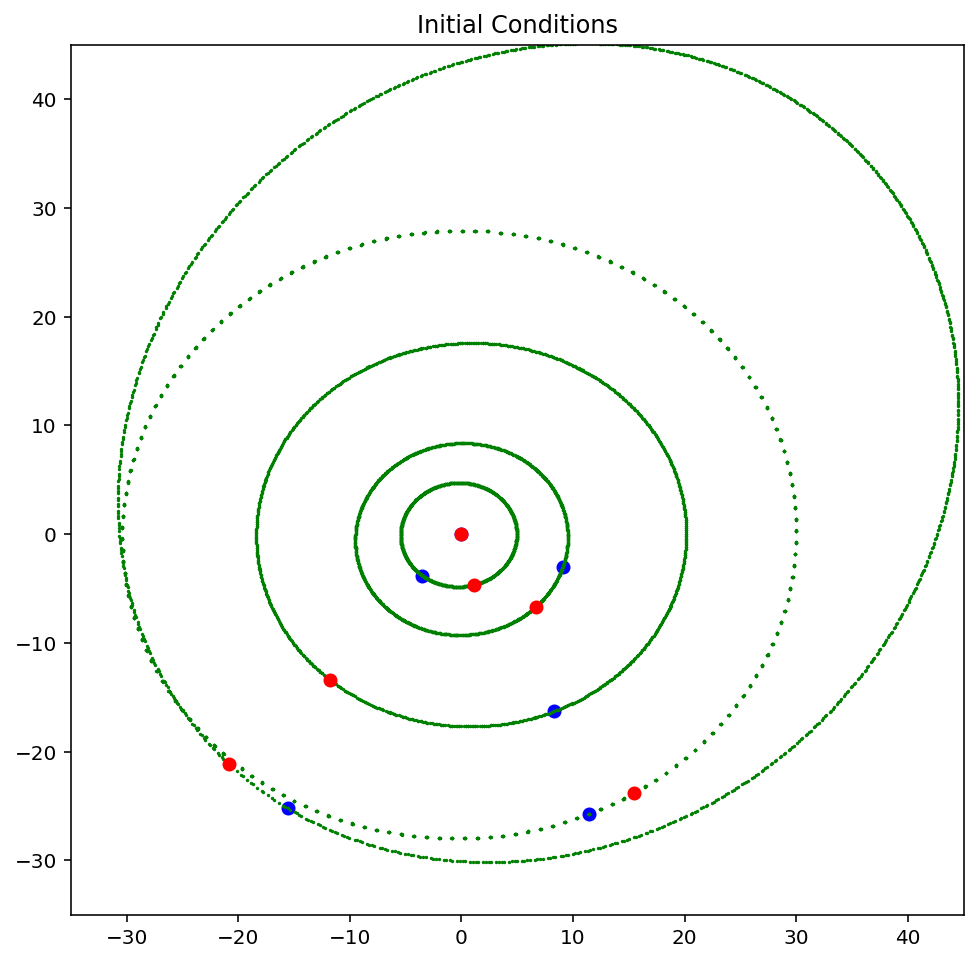

In [6]:
nsamples = 1001
tsamples = np.linspace(0, 1000, nsamples, endpoint=True)
xyz2 = np.zeros((nsamples, 6, 3))
vxyz2 = np.zeros((nsamples, 6, 3))
xyz2[0] = xyz
vxyz2[0] = vxyz
for i in range(1,nsamples):
    xyz2[i], vxyz2[i] = WHMap(xyz2[i-1], vxyz2[i-1], mass, 1.)
fig,axs = plt.subplots(1,1, figsize=(8,8))
axs.scatter(xyz[:,0], xyz[:,1], c='b')
axs.scatter(xyz2[:,:,0], xyz2[:,:,1], c='g', s=0.5)
axs.scatter(xyz2[-1,:,0], xyz2[-1,:,1], c='r')
axs.set_title('Initial Conditions')
axs.set_xlim([-35, 45])
axs.set_ylim([-35, 45])
plt.show()

## Rebound Simulation

In [7]:
import rebound
import numpy as np
from ctypes import c_double, byref, c_int
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pi = np.pi
twopi = 2.*np.pi

In [8]:
mass = np.array([1., 0.000954786104043, 0.000285583733151, 0.0000437273164546, 0.0000517759138449, 1./(1.3e8)])
xyz = np.array([[0., 0., 0.], [-3.5023653, -3.8169847, -1.5507963], [9.0755314, -3.0458353, -1.6483708],
                [8.3101420, -16.2901086, -7.2521278], [11.4707666, -25.7294829, -10.8169456], 
                [-15.5387357, -25.2225594, -3.1902382]])
vxyz = np.array([[0., 0., 0.], [5.65429, -4.12490, -1.90589], [1.68318, 4.83525, 1.92462], [3.54178, 1.37102, 0.55029],
                [2.88930, 1.14527, 0.39677], [2.76725, -1.70702, -1.36504]]) * (1.0e-3) * (365.25/twopi)

In [9]:
sim = rebound.Simulation()
for i in range(6):
    sim.add(m=mass[i], x=xyz[i,0], y=xyz[i,1], z=xyz[i,2], vx=vxyz[i,0], vy=vxyz[i,1], vz=vxyz[i,2])
sim.integrator = 'whfast'
sim.dt = twopi
sim.move_to_com()

CPU times: user 76.2 ms, sys: 10 ms, total: 86.3 ms
Wall time: 60.2 ms


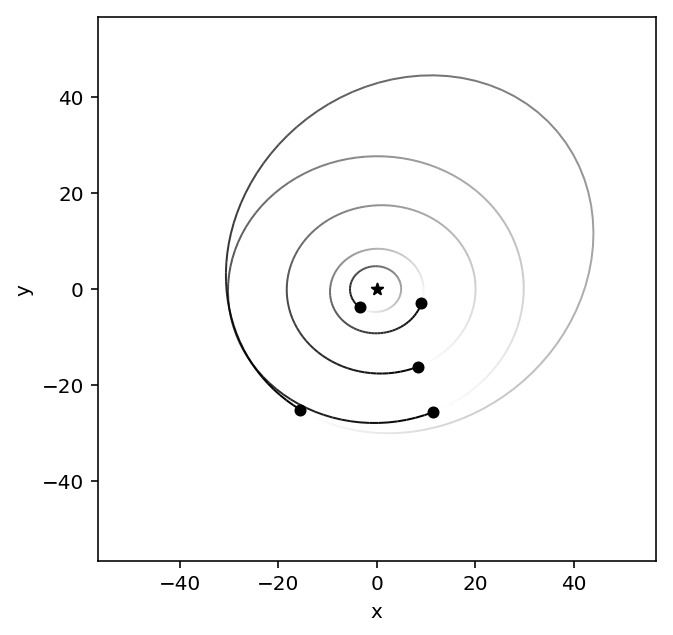

In [10]:
%%time
fig = rebound.OrbitPlot(sim);

### Comparison

In [11]:
nsamples = 1001
tsamples = np.linspace(0, 1000*twopi, nsamples, endpoint=True)
xyz3 = np.zeros((nsamples, 6, 3))
vxyz3 = np.zeros((nsamples, 6, 3))
for i in range(nsamples):
    sim.integrate(tsamples[i])
    for j in range(6):
        xyz3[i,j] = sim.particles[j].xyz
        vxyz3[i,j] = sim.particles[j].vxyz

In [12]:
print(np.mean(np.abs(xyz2-xyz3), axis=0),'\n')
print(np.mean(np.abs(vxyz2-vxyz3), axis=0))

[[3.51894991e-03 3.25463163e-03 1.38669541e-03]
 [1.58775403e+00 1.45551203e+00 6.24925773e-01]
 [5.42308167e-01 4.98459856e-01 2.03651816e-01]
 [3.10628195e+00 2.87684761e+00 1.26206931e+00]
 [2.72750037e+00 2.44752351e+00 1.00331925e+00]
 [3.98864357e+00 4.08351914e+00 1.64832982e+00]] 

[[2.70230386e-04 2.47925238e-04 1.06145573e-04]
 [1.33581966e-01 1.23055502e-01 5.28387273e-02]
 [1.82469431e-02 1.69982899e-02 6.94905156e-03]
 [3.74330113e-02 3.38386571e-02 1.48339064e-02]
 [1.59521518e-02 1.52428810e-02 6.24375962e-03]
 [1.74455427e-02 1.66182785e-02 6.89720615e-03]]


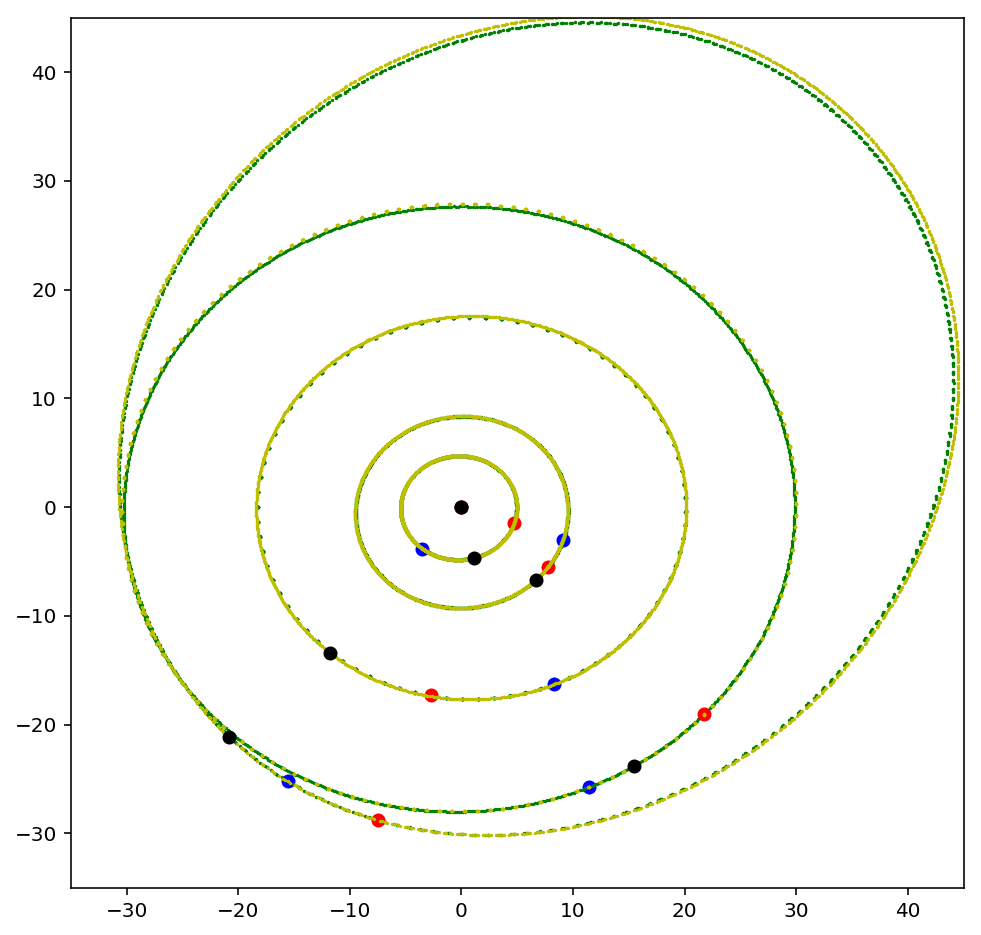

In [13]:
fig,axs = plt.subplots(1,1, figsize=(8,8))
axs.scatter(xyz[:,0], xyz[:,1], c='b')
axs.scatter(xyz3[:,:,0], xyz3[:,:,1], c='g', s=0.5)
axs.scatter(xyz3[-1,:,0], xyz3[-1,:,1], c='r')
axs.scatter(xyz2[:,:,0], xyz2[:,:,1], c='y', s=0.5)
axs.scatter(xyz2[-1,:,0], xyz2[-1,:,1], c='k')
axs.set_xlim([-35, 45])
axs.set_ylim([-35, 45])
plt.show()

## Errors

In [14]:
# Maybe I'll get to this later.